# Convolutional Neural Network Object Detection
In this notebook, state-of-the-art models for object detection are used on some example images. First, Faster R-CNN will be covered. Subsequently, YOLO will be used for object detection.

## Faster R-CNN

### **Import Libraries**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import argparse
import cv2
import numpy as np
import matplotlib.pyplot as plt

from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names # the coco_names python script contains the classes of the objects
from PIL import Image


c:\Users\Quinten Danneels\Documents\WP2 notebooks\Test\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Faster R-CNN**
The pre-trained Faster R-CNN model will be loaded here. The model has a ResNet50 base network and will be loaded from the torchvision module. The min_size argument denotes the minimum dimensions of the bounding boxes that surround the objects. Making this value smaller will result in more small object to be detected.  

In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,min_size=800)

c:\Users\Quinten Danneels\Documents\WP2 notebooks\Test\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Quinten Danneels\Documents\WP2 notebooks\Test\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Predicting the Object Classes**
A function is written here to detect objects and predict its classes and bounding boxes with the pre-trained Faster R-CNN. 

The torchvision model takes as input an image in the form of a tensor with dimensions [batch_size x channels x height x width]. Therefore the image needs to be transformed to a tensor. 

In [3]:
transform = transforms.ToTensor()

In [4]:
def predict(image,model,detection_threshold):
    image = transform(image)
    image = image.unsqueeze(0) # adding a batch dimension because we only work with single images
    outputs = model(image) 

    print(f"Boxes: {outputs[0]['boxes']}")
    print(f"Labels: {outputs[0]['labels']}")
    print(f"Scores: {outputs[0]['scores']}")

    # get all the predicted class labels
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].numpy()]

    # get all the scores for the predicted objects
    pred_scores = outputs[0]['scores'].detach().numpy()

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().numpy()

    # if the score is above the pre-defined threshold, then the bounding box is considered
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

### **Drawing the Bounding Box**
A function is written here to draw the bounding boxes around the detected objects in the image.  

In the image there can be many objects of different classes. Therefore, bounding boxes of similar classes need to have the same colour. This helps in visualising of the detections. 

In [5]:
COLORS = np.random.uniform(0,255,size=(len(coco_names),3)) # 3 dimensional vectors for each label is created, the values range between 0 and 255
COLORS

array([[123.48075186,  73.92799626, 223.94542466],
       [163.97518283, 107.54725324, 149.67667593],
       [193.44352098, 169.79850867, 233.09999435],
       [166.54612272, 202.62034713, 185.52641595],
       [ 42.28771528,  22.76402092,   7.64095573],
       [137.30603117, 121.12516876,  52.64644786],
       [103.10595361,  92.73616978, 116.91804925],
       [ 94.02892301,  99.86068373, 105.2025249 ],
       [178.73768096, 192.16518422, 236.61198427],
       [ 27.65813369,  27.96572352, 183.29918919],
       [241.4392651 ,  66.53069029, 249.94982306],
       [244.72227273, 141.18222004, 180.99349117],
       [132.87836467, 162.88608138,  16.42931841],
       [ 89.28164382, 247.08779233, 187.04201613],
       [144.1918526 , 130.3833348 , 155.20736061],
       [ 97.35464615, 247.89973886, 126.42464466],
       [179.78433625, 215.86268628, 195.99486036],
       [148.00764123, 222.23412707, 236.69823219],
       [ 75.64559373, 117.1298518 , 109.81933698],
       [245.39843303, 150.83087

In [6]:
def draw_boxes(boxes,classes,labels,image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)

    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        start_x = int(box[0])
        start_y = int(box[1])
        end_x = int(box[2])
        end_y = int(box[3])
        cv2.rectangle(image,(start_x,start_y),(end_x,end_y),color,2) # rectangle needs the image, the starting box coordinates, the ending box coordinates, the color and the line thickness as input
        cv2.putText(image,classes[i],(start_x,start_y-5), cv2.FONT_HERSHEY_SIMPLEX,0.8,color,2) # putText needs the image, the starting coordinates of the text, the font, the size, the text color and the letter thickness as input

    return image

### **Results**

The Faster R-CNN model will be now used with the above defined functions to perform object detection on 3 image examples.

The Faster R-CNN model detects all the objects within the image. A bounding box is placed around the objects. These are annotated with only the class name.

In [7]:
images_ex = ['horses.jpg','people.jpg','street.jpg']

In [8]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Image example 1:

Boxes: tensor([[281.8718,  79.2813, 420.7066, 225.9756],
        [330.9542,  80.9836, 593.0887, 228.4178],
        [109.6094,  95.4172, 332.9265, 226.0391],
        [111.1188, 108.3175, 299.6678, 226.6196],
        [359.3416,  98.2549, 600.4446, 232.9423],
        [142.3595,  82.4780, 474.7170, 232.5669],
        [217.1376,  91.9965, 338.9271, 226.1556],
        [111.3001, 108.9320, 300.2287, 223.7775],
        [346.2997,  14.0222, 632.1669, 213.3478],
        [351.5600, 123.3581, 592.3284, 229.2103]], grad_fn=<StackBackward0>)
Labels: tensor([19, 19, 19, 18, 18, 19, 19, 21,  1, 22])
Scores: tensor([0.9977, 0.9913, 0.9898, 0.2787, 0.1807, 0.1448, 0.1275, 0.0993, 0.0854,
        0.0730], grad_fn=<IndexBackward0>)


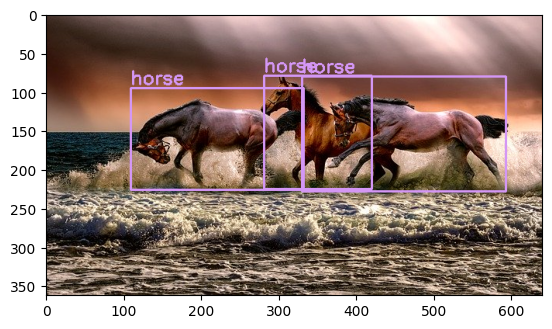

In [9]:
image = Image.open(images_ex[0])
boxes, classes, labels = predict(image,model,0.8)
image = draw_boxes(boxes,classes,labels,image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Image example 2:

Boxes: tensor([[ 838.6357,  332.8714,  931.3898,  610.8371],
        [ 235.5437,  160.7106,  430.6569,  690.1383],
        [1036.0819,  286.9707, 1156.6218,  604.0554],
        [ 718.0005,  406.3850,  778.0782,  582.8207],
        [ 490.6573,  387.9689,  557.2424,  599.1245],
        [ 762.8722,  405.6624,  821.9858,  584.3357],
        [ 608.5616,  386.3052,  668.2618,  598.7282],
        [ 455.2066,  407.0004,  505.5713,  588.4600],
        [ 572.2786,  409.2903,  619.7392,  594.0989],
        [ 654.2797,  413.5545,  704.2628,  587.6578],
        [ 376.1682,  346.8563,  469.2232,  622.5776],
        [ 184.0398,  191.8036,  311.2568,  613.2949],
        [ 869.4252,  368.6363,  920.3807,  477.0748],
        [ 463.3396,  441.3140,  502.3931,  502.6069],
        [ 685.6664,  444.3586,  713.8292,  519.5699],
        [1125.1453,  457.0604, 1159.7241,  500.2275],
        [ 179.3643,  366.9853,  238.8592,  446.9797],
        [1077.9030,  328.4338, 1087.2565,  336.9096],
        [ 606.8297,  

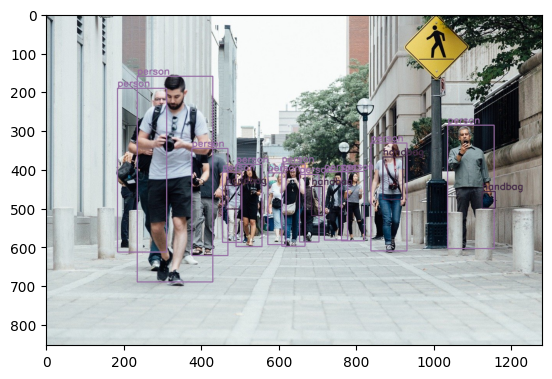

In [10]:
image = Image.open(images_ex[1])
boxes, classes, labels = predict(image,model,0.8)
image = draw_boxes(boxes,classes,labels,image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Image example 3:

Boxes: tensor([[5.8550e+02, 3.0679e+02, 7.6959e+02, 7.9109e+02],
        [6.1061e+02, 5.0469e+02, 7.7416e+02, 8.3717e+02],
        [3.5637e+02, 3.8366e+02, 4.2221e+02, 4.4126e+02],
        [3.7228e-01, 4.1606e+02, 2.8784e+01, 4.6788e+02],
        [5.5278e+02, 3.9554e+02, 5.7382e+02, 4.6087e+02],
        [2.5864e+01, 4.2121e+02, 6.5340e+01, 4.4425e+02],
        [8.1940e+02, 3.7355e+02, 8.4451e+02, 4.4950e+02],
        [1.5357e+02, 3.3876e+02, 4.9642e+02, 6.5111e+02],
        [1.3568e+02, 4.1083e+02, 1.4943e+02, 4.4751e+02],
        [9.4219e+02, 3.0277e+02, 9.6331e+02, 3.2791e+02],
        [6.9452e+01, 4.1938e+02, 1.1694e+02, 4.4502e+02],
        [2.4149e+01, 4.2302e+02, 4.6692e+01, 4.4643e+02],
        [1.1634e+03, 3.8943e+02, 1.2014e+03, 4.3058e+02],
        [1.1246e+03, 3.8154e+02, 1.1546e+03, 4.3327e+02],
        [1.0262e+03, 3.8537e+02, 1.0831e+03, 4.3714e+02],
        [7.7204e+02, 3.7843e+02, 7.9312e+02, 4.2867e+02],
        [1.0726e+03, 3.8711e+02, 1.1134e+03, 4.3559e+02],
       

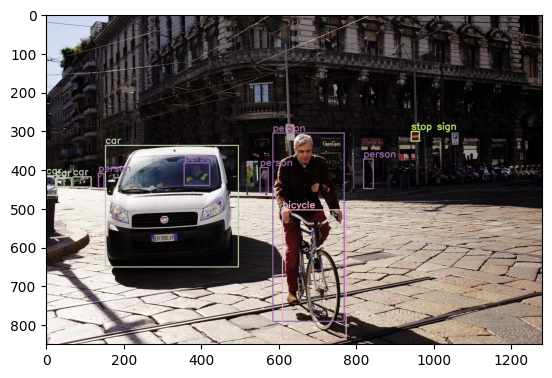

In [11]:
image = Image.open(images_ex[2])
boxes, classes, labels = predict(image,model,0.8)
image = draw_boxes(boxes,classes,labels,image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## **YOLO**

### **Import Libraries**

In [12]:
import torch
import cv2
from PIL import Image

### **YOLO v5**
The pre-trained YOLO v5 model will be loaded here from ultralytics. But first install the model requirements in your virtual environment: pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [13]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Quinten Danneels/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-8 Python-3.10.10 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


### **Images**
Some images from ultralytics are loaded here to perform object detection on. 

In [14]:
examples = ['zidane.jpg', 'bus.jpg', ]
for f in examples:
    torch.hub.download_url_to_file('https://ultralytics.com/images/' + f, f) 
im1 = Image.open('zidane.jpg')  # PIL image
im2 = cv2.imread('bus.jpg')[..., ::-1]  # OpenCV image (BGR to RGB)

100%|██████████| 165k/165k [00:00<00:00, 3.20MB/s]
100%|██████████| 476k/476k [00:00<00:00, 5.23MB/s]


### **Results**
The YOLO v5 model is now used to perform object detection on the 2 downloaded image examples. Batch interference is used. 

The YOLO v5 model detects all the objects within the image. A bounding box is placed around the objects. These are annotated with the class name and probability.

image 1/2: 720x1280 2 persons, 2 ties
image 2/2: 1080x810 4 persons, 1 bus
Speed: 11.9ms pre-process, 108.4ms inference, 1.0ms NMS per image at shape (2, 3, 640, 640)


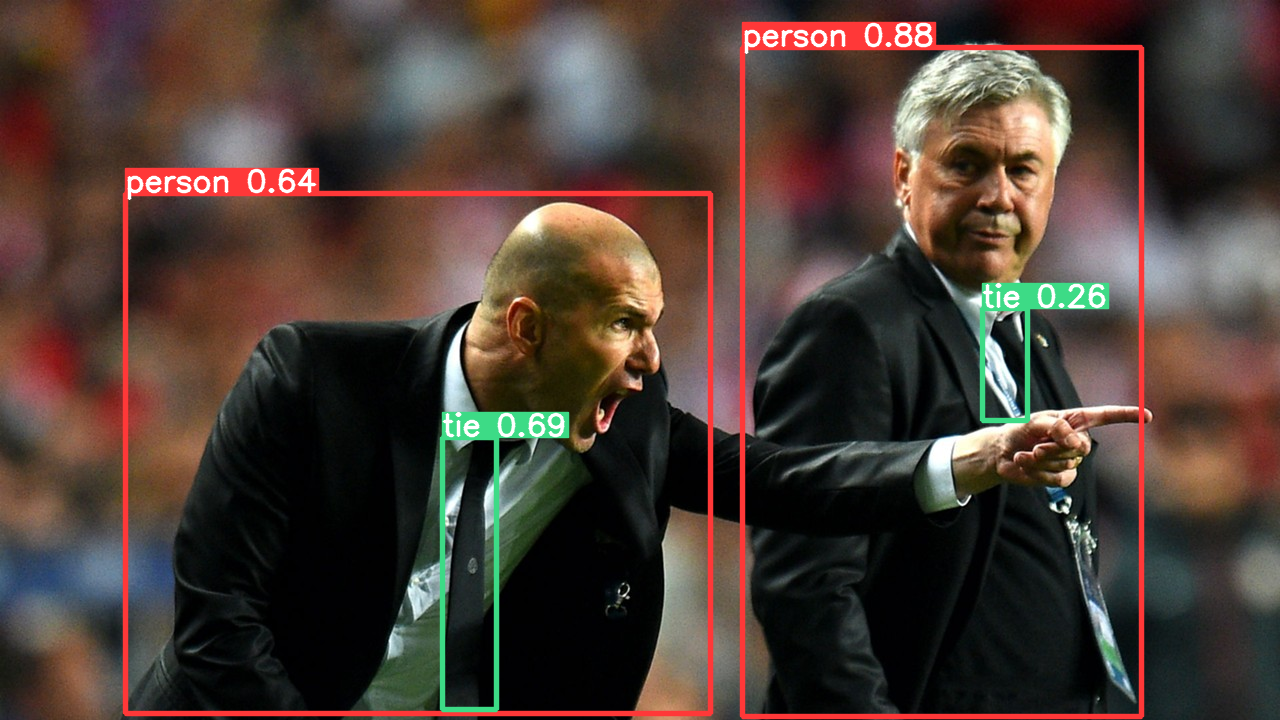

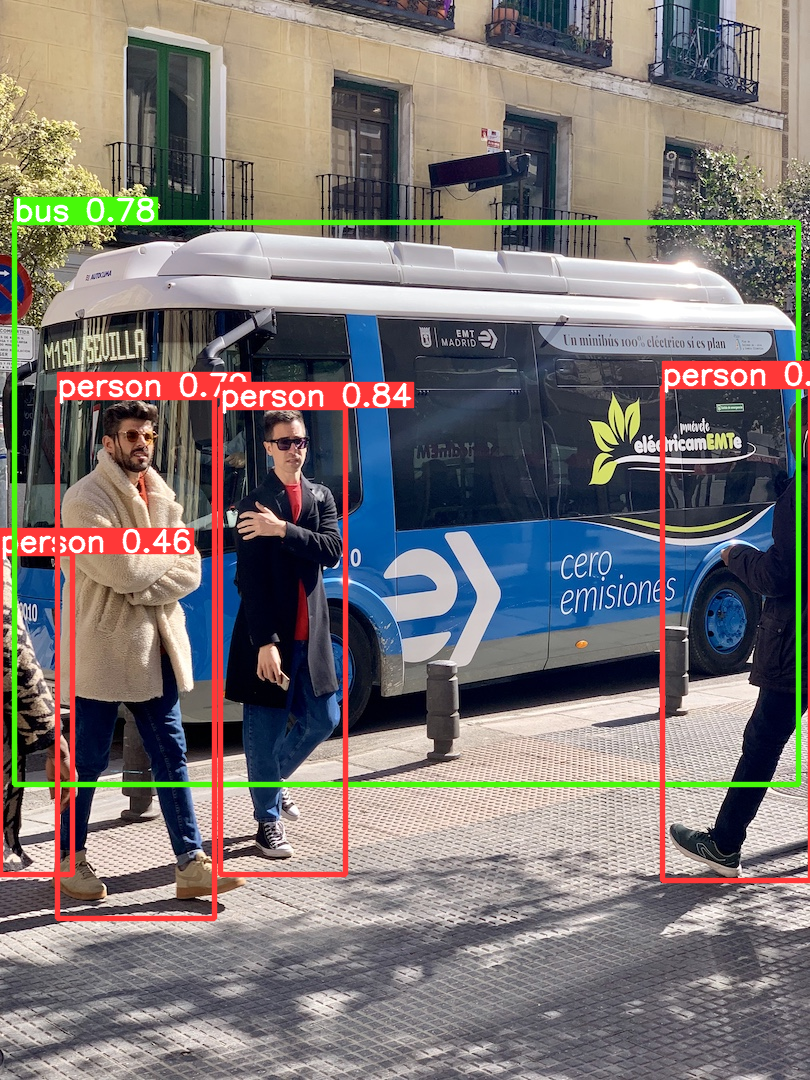

In [15]:
results = model([im1, im2], size=640) # size = batch of images
results.print()  
results.show()